In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import sys
import os
import struct
import time
import numpy as np
import h5py
from scipy.stats import pearsonr
from scipy.io import loadmat
from tqdm import tqdm
import pickle
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
root_dir = os.getcwd() + '/'
output_dir = root_dir + "output/"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print ("Current dir: %s" % root_dir)

Current dir: /md_disk7/guoyuan/Mufan/code/nsd-master/


## Load a dataset

In [4]:
nsd_root = "/md_disk7/guoyuan/Mufan/nsd/"
stim_root = nsd_root + "nsddata_stimuli/stimuli/nsd/"
beta_root = nsd_root + "nsddata_betas/ppdata/"
mask_root = nsd_root + "nsddata/ppdata/"
print (nsd_root)
print (stim_root)
print (beta_root)
print (mask_root)

/md_disk7/guoyuan/Mufan/nsd/
/md_disk7/guoyuan/Mufan/nsd/nsddata_stimuli/stimuli/nsd/
/md_disk7/guoyuan/Mufan/nsd/nsddata_betas/ppdata/
/md_disk7/guoyuan/Mufan/nsd/nsddata/ppdata/


In [5]:
from src.file_utility import load_mask_from_nii, view_data

def iterate_roi(group, voxelroi, roimap, group_name=None):
    for k,g in enumerate(group):
        g_name = ('' if group_name is None else group_name[k])
        mask = np.zeros(shape=voxelroi.shape, dtype=bool)
        for i,roi in enumerate(g):
            if group_name is None:
                g_name += roimap[roi] + ('-' if i+1<len(g) else '')
            mask = np.logical_or(mask, voxelroi==roi)
        yield mask, g_name

# Make early visual cortex masks

In [6]:
subjects = [1, 2, 3, 4, 5, 6, 7, 8]

In [7]:
roi_map = {1: 'V1v', 2: 'V1d', 3: 'V2v', 4: 'V2d', 5: 'V3v', 6: 'V3d', 7: 'v4'}
group_names = ['V1v', 'V1d', 'V2v', 'V2d', 'V3v', 'V3d', 'V4',]
group = [[1], [2], [3], [4], [5], [6], [7],]

for k,s in enumerate(subjects):
    print ('--------  subject %d  -------' % s)
    voxel_roi_full = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/prf-visualrois.nii.gz"%s)
    brain_nii_shape = voxel_roi_full.shape
    print (brain_nii_shape)

    general_mask_full = (voxel_roi_full>0).flatten().astype(bool)
    voxel_mask = general_mask_full
    voxel_idx = np.arange(len(general_mask_full))[voxel_mask]
    voxel_roi = voxel_roi_full.flatten()[voxel_mask]
    
    print ('mask selection length = %d'%np.sum(voxel_mask))
    print ('mask total length = %d'%len(voxel_mask))
    _ = view_data(brain_nii_shape, voxel_idx,  np.ones_like(voxel_idx), save_to=mask_root \
                  + "subj%02d/func1pt8mm/brainmask_vcventral_1.0.nii"%s)

--------  subject 1  -------
(81, 104, 83)
mask selection length = 4657
mask total length = 699192
--------  subject 2  -------
(82, 106, 84)
mask selection length = 3757
mask total length = 730128
--------  subject 3  -------
(81, 106, 82)
mask selection length = 3749
mask total length = 704052
--------  subject 4  -------
(85, 99, 80)
mask selection length = 3023
mask total length = 673200
--------  subject 5  -------
(79, 97, 78)
mask selection length = 3661
mask total length = 597714
--------  subject 6  -------
(85, 113, 83)
mask selection length = 3985
mask total length = 797215
--------  subject 7  -------
(78, 95, 81)
mask selection length = 3251
mask total length = 600210
--------  subject 8  -------
(80, 103, 78)
mask selection length = 3491
mask total length = 642720


## Example

/tmp/ipykernel_17663/4185017076.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_17663/4185017076.py:18: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


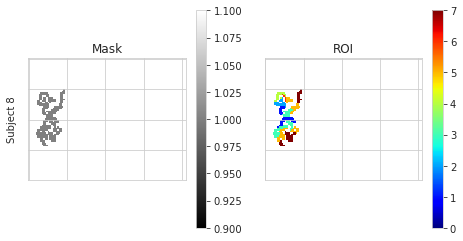

In [8]:
slice_idx = 25
plt.figure(figsize=(12, 4))
    
volume_brain_mask = view_data(brain_nii_shape, voxel_idx, np.ones_like(voxel_idx), save_to=None)
volume_brain_roi  = view_data(brain_nii_shape, voxel_idx, voxel_roi, save_to=None)
##
plt.subplot(1,3,1)
plt.imshow(volume_brain_mask[:,:,slice_idx], cmap='gray', interpolation='None')
plt.title('Mask')
plt.colorbar()
_=plt.ylabel('Subject %d'%s)
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])
plt.subplot(1,3,2)
plt.imshow(volume_brain_roi[:,:,slice_idx], cmap='jet', interpolation='None')
plt.clim([0,7])
plt.title('ROI')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])

# Make visual cortex masks

In [9]:
roi_map = {1: 'V1v', 2: 'V1d', 3: 'V2v', 4: 'V2d', 5: 'V3v', 6: 'V3d', 7: 'hV4', 8: 'VO1', 9: 'VO2', \
           10: 'PHC1', 11: 'PHC2', 12: 'MST', 13: 'hMT', 14: 'LO2', 15: 'LO1', 16: 'V3b', 17: 'V3a', \
           18: 'IPS0', 19: 'IPS1', 20: 'IPS2', 21: 'IPS3', 22: 'IPS4', 23: 'IPS5', 24: 'SPL1', 25: 'FEF',\
           0: 'other'}

for k,s in enumerate(subjects):
    print ('--------  subject %d  -------' % s)
    voxel_roi_full = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/prf-visualrois.nii.gz"%s)
    voxel_kast_full     = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/Kastner2015.nii.gz"%(s))
    general_mask_full  = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/nsdgeneral.nii.gz"%(s))
    ###
    
    brain_nii_shape = voxel_roi_full.shape
    print (brain_nii_shape)

    ###
    voxel_mask_full = (voxel_roi_full>0).flatten().astype(bool)
    voxel_joined_roi_full = np.copy(voxel_kast_full.flatten())  # take the kastner rois
    voxel_joined_roi_full[voxel_mask_full] = voxel_roi_full.flatten()[voxel_mask_full] # overwrite the prf visual rois
    voxel_joined_mask_full = (voxel_joined_roi_full>0).flatten().astype(bool)
    ###
    
    voxel_mask = voxel_joined_mask_full
    voxel_idx = np.arange(len(voxel_joined_mask_full))[voxel_mask]
    voxel_roi = voxel_joined_roi_full[voxel_mask]
        
    print ('(kastner selection length = %d)'%np.sum(voxel_kast_full>0))
    print ('mask selection length = %d'%np.sum(voxel_mask))
    print ('mask total length = %d'%len(voxel_mask))
    _ = view_data(brain_nii_shape, voxel_idx,  np.ones_like(voxel_idx), save_to=mask_root \
                  + "subj%02d/func1pt8mm/brainmask_nsdgeneral_1.0.nii"%s)

--------  subject 1  -------
(81, 104, 83)
(kastner selection length = 11067)
mask selection length = 11930
mask total length = 699192
--------  subject 2  -------
(82, 106, 84)
(kastner selection length = 9682)
mask selection length = 10285
mask total length = 730128
--------  subject 3  -------
(81, 106, 82)
(kastner selection length = 10538)
mask selection length = 11316
mask total length = 704052
--------  subject 4  -------
(85, 99, 80)
(kastner selection length = 8951)
mask selection length = 9449
mask total length = 673200
--------  subject 5  -------
(79, 97, 78)
(kastner selection length = 8968)
mask selection length = 9551
mask total length = 597714
--------  subject 6  -------
(85, 113, 83)
(kastner selection length = 11433)
mask selection length = 11799
mask total length = 797215
--------  subject 7  -------
(78, 95, 81)
(kastner selection length = 8442)
mask selection length = 9187
mask total length = 600210
--------  subject 8  -------
(80, 103, 78)
(kastner selection len

## Example

/tmp/ipykernel_17663/4185017076.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_17663/4185017076.py:18: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


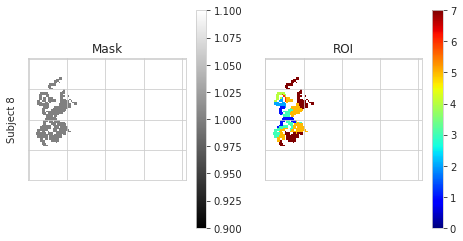

In [10]:
slice_idx = 25
plt.figure(figsize=(12, 4))
    
volume_brain_mask = view_data(brain_nii_shape, voxel_idx, np.ones_like(voxel_idx), save_to=None)
volume_brain_roi  = view_data(brain_nii_shape, voxel_idx, voxel_roi, save_to=None)
##
plt.subplot(1,3,1)
plt.imshow(volume_brain_mask[:,:,slice_idx], cmap='gray', interpolation='None')
plt.title('Mask')
plt.colorbar()
_=plt.ylabel('Subject %d'%s)
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])
plt.subplot(1,3,2)
plt.imshow(volume_brain_roi[:,:,slice_idx], cmap='jet', interpolation='None')
plt.clim([0,7])
plt.title('ROI')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])

# Make whole brain masks
## We need mask that are as tight as possible on the brain. The provided brainmasks are too loose and result in a prohibitive compute cost (almost half of the voxels can be entirely avoided)

In [11]:
subject = 1
brain_r2_full     = load_mask_from_nii(beta_root + "subj%02d/func1pt8mm/betas_fithrf_GLMdenoise_RR/R2.nii.gz"%(subject,))
brain_mask_full   = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/brainmask.nii.gz"%(subject))
brain_anat_full   = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/T1_to_func1pt8mm.nii.gz"%(subject))
brain_seg_full    = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/aseg.nii.gz"%(subject))
brain_roi_full    = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/Kastner2015.nii.gz"%(subject))
general_mask_full = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/nsdgeneral.nii.gz"%(subject))

brain_nii_shape = brain_mask_full.shape
brain_mask_full   = brain_mask_full.flatten().astype(bool)
general_mask_full = (general_mask_full==1).flatten().astype(bool)

voxel_seg_full = (brain_seg_full!=0).flatten()
voxel_idx_full = np.arange(len(brain_mask_full))
voxel_gen_full = (general_mask_full==1).flatten().astype(bool)
voxel_roi_full = brain_roi_full.flatten()

_ = view_data(brain_nii_shape, voxel_idx_full, brain_roi_full.flatten(), save_to=output_dir + "S%02d/roi_redo.nii"%(subject))
_ = view_data(brain_nii_shape, voxel_idx_full, brain_seg_full.flatten(), save_to=output_dir + "S%02d/aseg_redo.nii"%(subject))
_ = view_data(brain_nii_shape, voxel_idx_full, brain_anat_full.flatten(), save_to=output_dir + "S%02d/anat_redo.nii"%(subject))

voxel_seg_brain = voxel_seg_full[brain_mask_full]
voxel_idx_brain = voxel_idx_full[brain_mask_full]
voxel_roi_brain = voxel_roi_full[brain_mask_full]
voxel_gen_brain = voxel_gen_full[brain_mask_full]

voxel_seg_general = voxel_seg_full[general_mask_full]
voxel_idx_general = voxel_idx_full[general_mask_full]
voxel_roi_general = voxel_roi_full[general_mask_full]

/tmp/ipykernel_17663/533344422.py:14: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_17663/533344422.py:21: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_17663/533344422.py:27: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_17663/533344422.py:33: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_17663/533344422.py:40: MatplotlibDepr

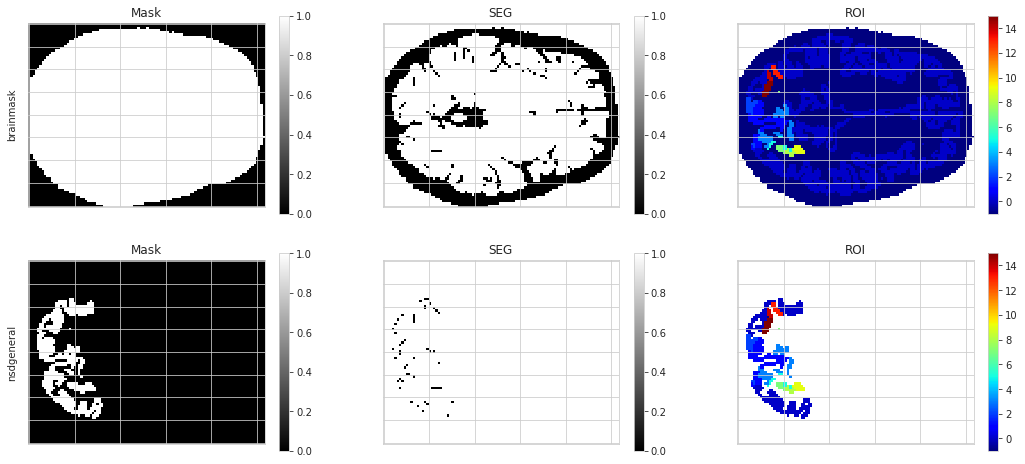

In [12]:
volume_brain_mask = view_data(brain_nii_shape, voxel_idx_full, brain_mask_full)
volume_brain_seg  = view_data(brain_nii_shape, voxel_idx_brain, voxel_seg_brain)
volume_brain_roi  = view_data(brain_nii_shape, voxel_idx_brain, voxel_roi_brain)

volume_general_mask = view_data(brain_nii_shape, voxel_idx_full, general_mask_full)
volume_general_seg  = view_data(brain_nii_shape, voxel_idx_general, voxel_seg_general)
volume_general_roi  = view_data(brain_nii_shape, voxel_idx_general, voxel_roi_general)

slice_idx = 40
fig = plt.figure(figsize=(18,8))
plt.subplot(2,3,1)
plt.imshow(volume_brain_mask[:,:,slice_idx], cmap='gray', interpolation='None')
plt.title('Mask')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])
plt.ylabel('brainmask')
plt.subplot(2,3,2)
plt.imshow(volume_brain_seg[:,:,slice_idx], cmap='gray', interpolation='None')
plt.title('SEG')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])
plt.subplot(2,3,3)
plt.imshow(volume_brain_roi[:,:,slice_idx], cmap='jet', interpolation='None')
plt.title('ROI')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])
plt.subplot(2,3,4)
plt.imshow(volume_general_mask[:,:,slice_idx], cmap='gray', interpolation='None')
plt.title('Mask')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])
plt.ylabel('nsdgeneral')
plt.subplot(2,3,5)
plt.imshow(volume_general_seg[:,:,slice_idx], cmap='gray', interpolation='None')
plt.title('SEG')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])
plt.subplot(2,3,6)
plt.imshow(volume_general_roi[:,:,slice_idx], cmap='jet', interpolation='None')
plt.title('ROI')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])

In [13]:
tight_mask = np.logical_or(np.logical_or(voxel_seg_full, voxel_gen_full), voxel_roi_full>=0)

voxel_idx_tight = voxel_idx_full[tight_mask]
voxel_roi_tight = voxel_roi_full[tight_mask]

/tmp/ipykernel_17663/3962273789.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_17663/3962273789.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


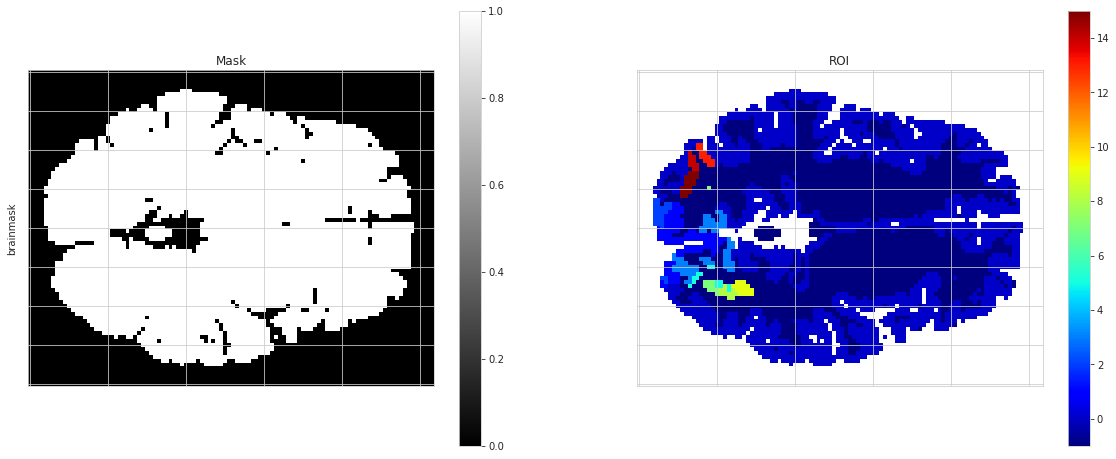

In [14]:
volume_tight_mask = view_data(brain_nii_shape, voxel_idx_full, tight_mask)
volume_tight_roi  = view_data(brain_nii_shape, voxel_idx_tight, voxel_roi_tight)

slice_idx = 40
fig = plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.imshow(volume_tight_mask[:,:,slice_idx], cmap='gray', interpolation='None')
plt.title('Mask')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])
plt.ylabel('brainmask')
plt.subplot(1,2,2)
plt.imshow(volume_tight_roi[:,:,slice_idx], cmap='jet', interpolation='None')
plt.title('ROI')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])

In [15]:
print ('tight masks voxel coverage = %d'%np.sum(tight_mask))
print ('original mask voxel coverage = %d'%np.sum(brain_mask_full))

tight masks voxel coverage = 206329
original mask voxel coverage = 370503


## Let's inflate the tight mask just a tiny bit to fill the ugly holes

In [16]:
def inflate1d(x):
    y = x.astype(np.float32)
    return 1.*y + 0.5*np.roll(y,-1,axis=0) + 0.5*np.roll(y,1,axis=0)

def inflate2d(x):
    y = inflate1d(x)
    return 1.*y + 0.5*np.roll(y,-1,axis=1) + 0.5*np.roll(y,1,axis=1)

def inflate3d(x):
    y = inflate2d(x)
    return 1.*y + 0.5*np.roll(y,-1,axis=2) + 0.5*np.roll(y,1,axis=2)

In [17]:
volume_inflated_mask = inflate3d(volume_tight_mask)>=1.

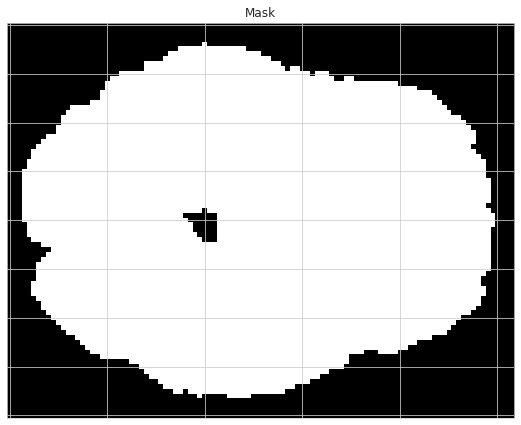

In [18]:
slice_idx = 40
fig = plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.imshow(volume_inflated_mask[:,:,slice_idx], cmap='gray', interpolation='None')
plt.title('Mask')
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])

In [19]:
print ('tight masks voxel coverage = %d'%np.sum(tight_mask))
print ('inflated tight masks voxel coverage = %d'%np.sum(volume_inflated_mask))
print ('original mask voxel coverage = %d'%np.sum(brain_mask_full))

tight masks voxel coverage = 206329
inflated tight masks voxel coverage = 238292
original mask voxel coverage = 370503


In [20]:
inflated_mask = volume_inflated_mask.flatten()

voxel_idx_inflated = voxel_idx_full[inflated_mask]
voxel_roi_inflated = voxel_roi_full[inflated_mask]

/tmp/ipykernel_17663/588229442.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_17663/588229442.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


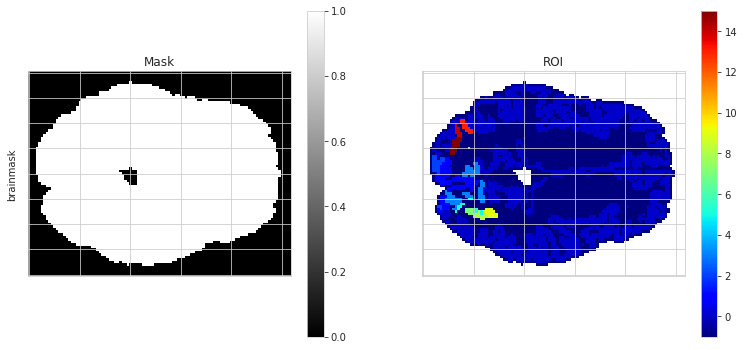

In [21]:
volume_inflated_mask = view_data(brain_nii_shape, voxel_idx_full, inflated_mask)
volume_inflated_roi  = view_data(brain_nii_shape, voxel_idx_inflated, voxel_roi_inflated)

slice_idx = 40
fig = plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
plt.imshow(volume_inflated_mask[:,:,slice_idx], cmap='gray', interpolation='None')
plt.title('Mask')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])
plt.ylabel('brainmask')
plt.subplot(1,3,2)
plt.imshow(volume_inflated_roi[:,:,slice_idx], cmap='jet', interpolation='None')
plt.title('ROI')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])

# Create slightly inflated mask for all subjects

In [22]:
for s in subjects:
    print ('subject = %d' % s)
    brain_mask_full   = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/brainmask.nii.gz"%s)
    brain_seg_full    = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/aseg.nii.gz"%s)
    brain_roi_full    = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/Kastner2015.nii.gz"%s)
    general_mask_full = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/nsdgeneral.nii.gz"%s)
    
    brain_nii_shape = brain_mask_full.shape
    brain_mask_full   = brain_mask_full.flatten().astype(bool)
    general_mask_full = (general_mask_full==1).flatten().astype(bool)

    voxel_seg_full = (brain_seg_full!=0).flatten()
    voxel_idx_full = np.arange(len(brain_mask_full))
    voxel_gen_full = (general_mask_full==1).flatten().astype(bool)
    voxel_roi_full = brain_roi_full.flatten()
    ###
    tight_mask = np.logical_or(np.logical_or(voxel_seg_full, voxel_gen_full), voxel_roi_full>=0)
    volume_tight_mask = view_data(brain_nii_shape, voxel_idx_full, tight_mask)
    volume_inflated_mask = inflate3d(volume_tight_mask)>=1.
    inflated_mask = volume_inflated_mask.flatten()
    ###
    print ("   tight  \t<  inflated  \t<  original")
    print ("   %d  \t<  %d  \t<  %d"%(np.sum(tight_mask), np.sum(volume_inflated_mask.flatten()), np.sum(brain_mask_full.flatten())))
    _ = view_data(brain_nii_shape, voxel_idx_full, inflated_mask, save_to=mask_root + "subj%02d/func1pt8mm/brainmask_inflated_1.0.nii"%s)

subject = 1
   tight  	<  inflated  	<  original
   206329  	<  238292  	<  370503
subject = 2
   tight  	<  inflated  	<  original
   213680  	<  242431  	<  343107
subject = 3
   tight  	<  inflated  	<  original
   216033  	<  246490  	<  358199
subject = 4
   tight  	<  inflated  	<  original
   199876  	<  229277  	<  329650
subject = 5
   tight  	<  inflated  	<  original
   178010  	<  205599  	<  302566
subject = 6
   tight  	<  inflated  	<  original
   241796  	<  274948  	<  412281
subject = 7
   tight  	<  inflated  	<  original
   174697  	<  199766  	<  296155
subject = 8
   tight  	<  inflated  	<  original
   205478  	<  234817  	<  321595
